<a href="https://colab.research.google.com/github/antahiap/dsr-b35/blob/main/08_multivariate_forecasting_with_DARTS_and_N_BEATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate Time Series Forecasting with DARTS - N-BEATS

* https://medium.com/unit8-machine-learning-publication/training-forecasting-models-on-multiple-time-series-with-darts-dc4be70b1844



The [N-BEATS](https://arxiv.org/abs/1905.10437) algorithm is one of the most successful neural network architectures for time series forecasting.

In [ ]:
!pip install darts -q

In [ ]:
# Here get two datasets that have nothing to do with each other
# History of Air travel usage vs History of Milk Production
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

In [ ]:
AirPassengersDataset().load().pd_series()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Length: 144, dtype: float64

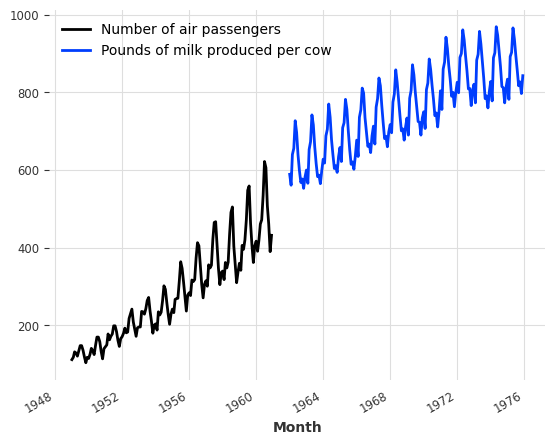

In [ ]:
import matplotlib.pyplot as plt
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

# Note that the data
series_air.plot(label='Number of air passengers')
series_milk.plot(label='Pounds of milk produced per cow')
plt.legend();

---

## Data Scaling Using Scaler

In this cell, we use the `Scaler` class from Darts to scale the features of our time series data. Feature scaling is a method used to normalize the range of independent variables or features of the data. This is crucial for algorithms that are sensitive to the magnitude of the input.

### Steps in this Cell

1. **Import Scaler**: We import the `Scaler` class from `darts.dataprocessing.transformers`.
2. **Create Scaler Instances**: Two separate instances of `Scaler` are created for the "air" and "milk" data series.
3. **Fit and Transform**: The `fit_transform()` method is called on each scaler instance. This method calculates the necessary parameters to perform scaling (like mean and standard deviation) and then applies the scaling transformation.
4. **Plotting**: Finally, we plot the scaled series to visualize the effect of scaling.

By scaling the data, we make sure that our forecasting model isn't biased towards variables with higher magnitudes.

---

## Sensitivity of Algorithms to Magnitude of Input

Several machine learning algorithms are sensitive to the scale of the input features. Here are some examples:

1. **K-Nearest Neighbors (K-NN)**: The distance between neighbors is crucial. Features on larger scales can distort the distance metric.
2. **Support Vector Machines (SVM)**: The hyperplane's effectiveness is influenced by the scale of the input variables.
3. **Gradient Descent Based Algorithms**: Algorithms like linear regression, logistic regression, and neural networks that use gradient descent are sensitive to the scale of the features.
4. **Principal Component Analysis (PCA)**: Features with large scales can dominate the first principal component.
5. **Clustering Algorithms**: Algorithms like K-means depend on the distance metric and are sensitive to the scale.
6. **Regularization Techniques**: Methods like Lasso and Ridge regression are sensitive to the scale of the input features.

---

## Sensitivity of Gradient Boosting Algorithms to Magnitude of Input

Gradient Boosting algorithms like XGBoost, LightGBM, and Gradient Boosting Machine (GBM) are generally not very sensitive to the scale of the input variables. These algorithms are primarily based on decision trees, which split the data based on the value of features, and these splits are not influenced by the scale of the feature.

### Why Gradient Boosting Algorithms are Less Sensitive to Scaling:

1. **Tree-based Models**: They construct decision trees for prediction, and decision trees are not sensitive to the scale of the features.
  
2. **No Distance Metric**: These algorithms do not rely on distance metrics for training, unlike algorithms like K-NN or K-means, which are sensitive to the scale of the features.

3. **Implicit Feature Selection**: Gradient Boosting algorithms can implicitly perform feature selection, focusing on features that help improve the prediction, regardless of their scale.

While the algorithms themselves may not be sensitive to feature scaling, interpretability and comparison of feature importances could be easier when the features are on the same scale.

---



### Is N-BEATS Sensitive to the Magnitude?

N-BEATS (Neural Basis Expansion Analysis for Time Series) is generally less sensitive to the scale of the input features compared to traditional distance-based algorithms. However, it's a good practice to scale your inputs, especially when comparing performance across multiple algorithms.

---


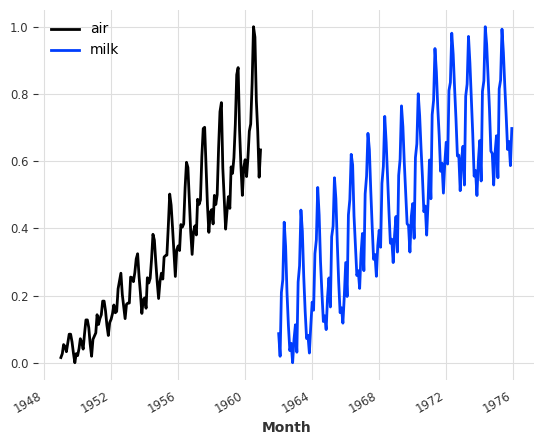

In [ ]:
from darts.dataprocessing.transformers import Scaler
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label='air')
series_milk_scaled.plot(label='milk')
plt.legend();

In [ ]:
# Train And Validation Split
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

In [ ]:
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape

In [ ]:
model_air_milk = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0)

In [ ]:
model_air_milk.fit([train_air, train_milk], verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 7.16%


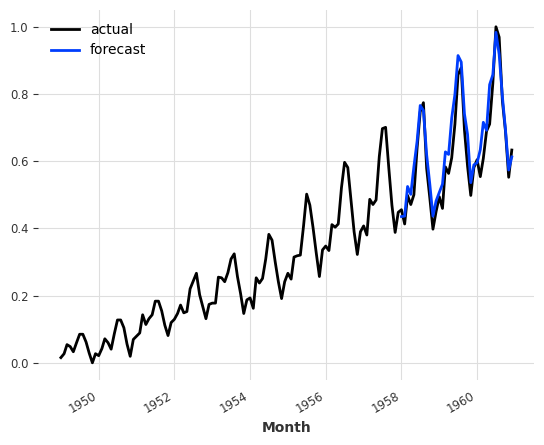

In [ ]:
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_air_scaled, pred)))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 13.34%


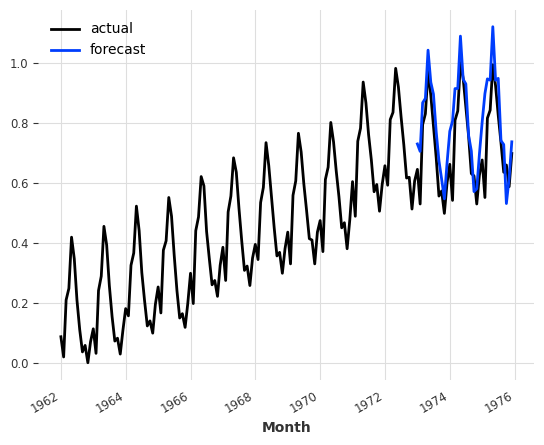

In [ ]:
pred = model_air_milk.predict(n=36, series=train_milk)

series_milk_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_milk_scaled, pred)))

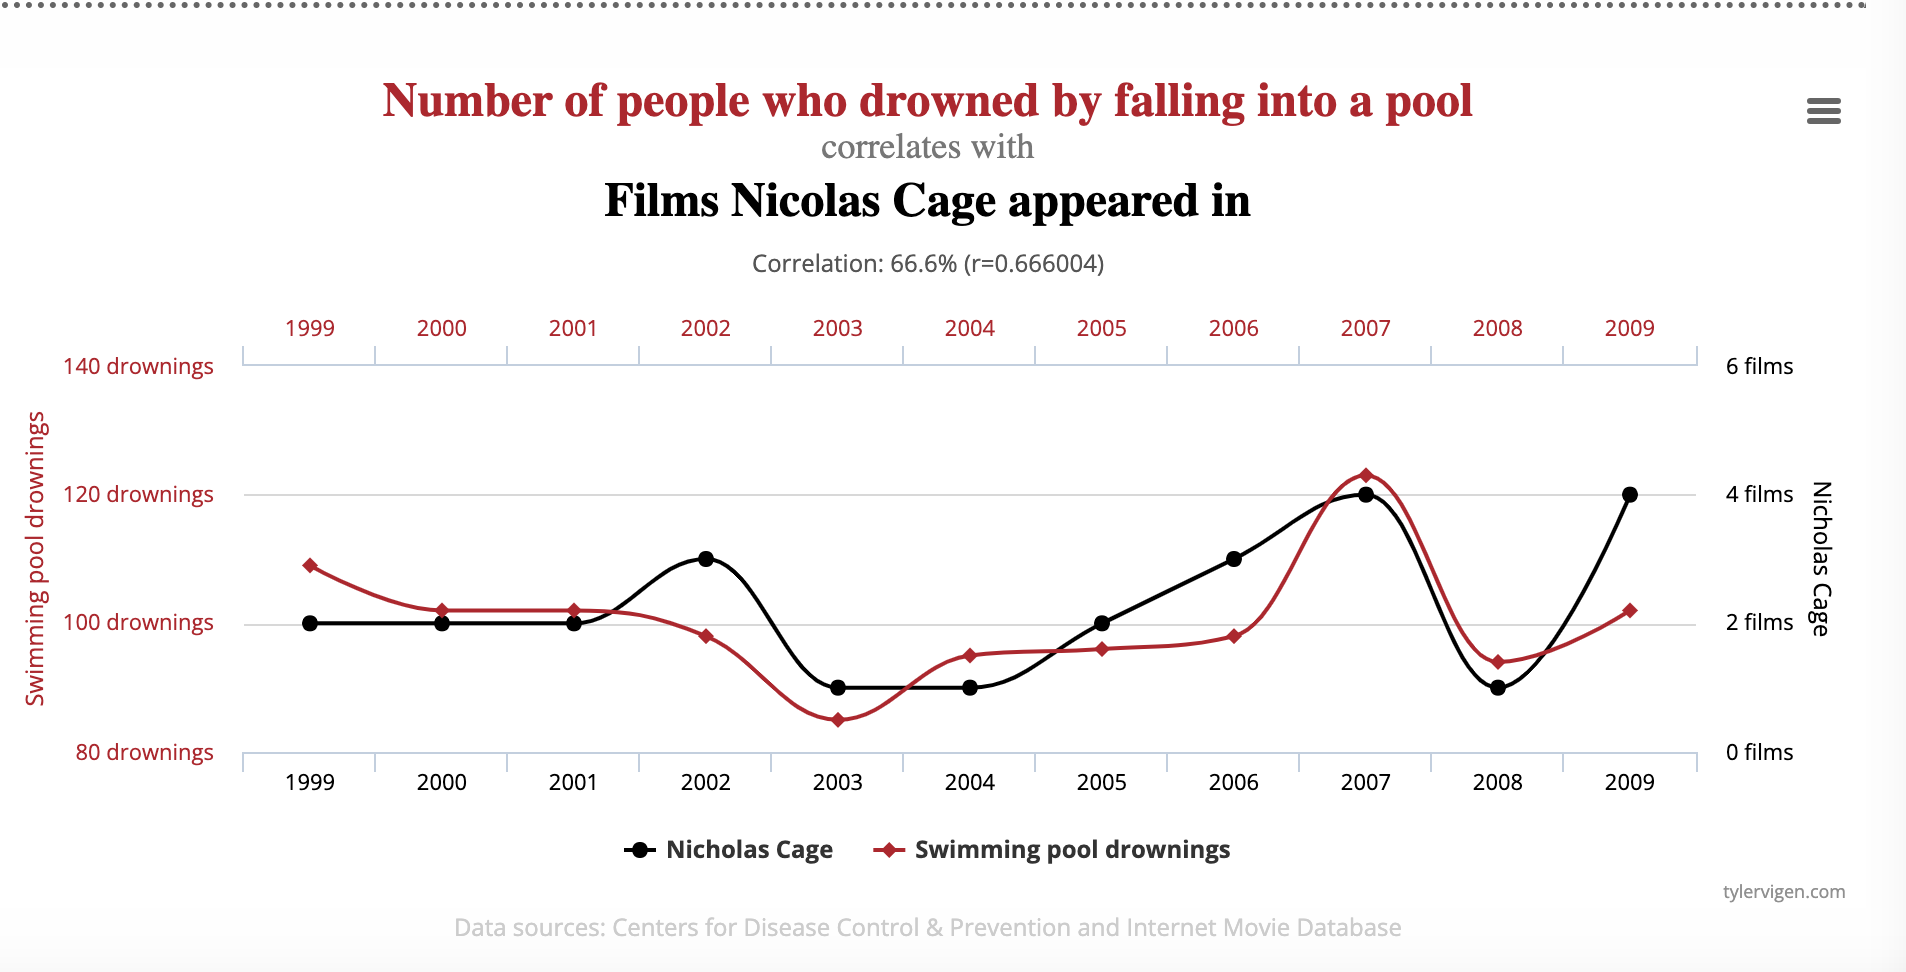